# DSCI 417 - Homework 07
**Lauren Forti**

In [0]:
# setup
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

spark = SparkSession.builder.getOrCreate()

## Problem 1: Decision Tree Classification

<pre>
+----+----+----+----+----+-----------+
| x0 | x1 | x2 | x3 | x4 | prediction| Leaf Node
+----+----+----+----+----+-----------+ ---------
| 3.7| 5.6| 3.6| 2.0| 1.0|    0      |     3
| 8.2| 4.2| 2.1| 2.0| 0.0|    0      |     7
| 5.4| 3.9| 4.9| 1.0| 1.0|    1      |     6
| 2.8| 6.1| 8.1| 0.0| 0.0|    2      |     2
+----+----+----+----+----+-----------+
</pre>

## Problem 2: Random Forest Classification

<pre>
Tree Model 1 Prediction:  0.0
Tree Model 2 Prediction:  0.0
Tree Model 3 Prediction:  1.0
Random Forest Prediction: 0.0
</pre>

## Problem 3: Load and Process Stroke Data

In [0]:
# read file into df
stroke_df = (
    spark.read
    .option('delimiter', ',')
    .option('header', True)
    .schema('gender STRING, age DOUBLE, hyptertension INTEGER, heart_disease INTEGER, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING, stroke INTEGER')
    .csv('/FileStore/tables/stroke_data.csv')
)

# display schema
stroke_df.printSchema()

root
-- gender: string (nullable = true)
-- age: double (nullable = true)
-- hyptertension: integer (nullable = true)
-- heart_disease: integer (nullable = true)
-- ever_married: string (nullable = true)
-- work_type: string (nullable = true)
-- residence_type: string (nullable = true)
-- avg_glucose_level: double (nullable = true)
-- bmi: double (nullable = true)
-- smoking_status: string (nullable = true)
-- stroke: integer (nullable = true)

In [0]:
# lists to store names of cols for features
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]

# lists to store int encoded cat cols
ix_features = [c + '_ix' for c in cat_features]

# use cols in cat_features to create cols in ix_features
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)

# combine num features and one-hot encoded features
assembler = VectorAssembler(inputCols=num_features + ix_features, outputCol='features')

In [0]:
# create pipeline w/ previously created objs then fit to df
pre_pipe = Pipeline(stages=[feature_indexer, assembler]).fit(stroke_df)

# store processed df
train = pre_pipe.transform(stroke_df)

# persist the train df
train.persist()

# display df
train.select(['features', 'stroke']).show(10, truncate=False)

+----------------------------------------------+------+
features |stroke|
+----------------------------------------------+------+
(10,[0,1,2,6],[13.0,77.63,31.7,1.0]) |0 |
[10.0,84.02,18.7,1.0,0.0,0.0,1.0,3.0,1.0,0.0] |0 |
[82.0,88.6,32.5,0.0,0.0,1.0,0.0,1.0,1.0,1.0] |0 |
[3.0,57.33,16.8,0.0,0.0,0.0,1.0,3.0,0.0,1.0] |0 |
[65.0,220.52,37.2,0.0,0.0,0.0,0.0,1.0,1.0,3.0]|0 |
(10,[0,1,2,7,8],[65.0,100.65,31.0,1.0,1.0]) |1 |
[65.0,56.64,28.4,1.0,0.0,0.0,0.0,0.0,1.0,2.0] |1 |
(10,[0,1,2,8],[28.0,64.64,22.1,1.0]) |0 |
(10,[0,1,2,7,9],[80.0,84.86,29.3,2.0,1.0]) |0 |
(10,[0,1,2,3,9],[78.0,60.22,29.7,1.0,2.0]) |0 |
+----------------------------------------------+------+
only showing top 10 rows

## Problem 4: Hyperparameter Tuning for Decision Trees

In [0]:
# calc accuracy
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='stroke', metricName='accuracy')

# create decision tree
dtree = DecisionTreeClassifier(featuresCol='features', labelCol='stroke', seed=1)

# set params
param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [2, 4, 6, 8, 10, 12, 14, 16] )
              .addGrid(dtree.minInstancesPerNode, [4, 8, 16, 32])
             ).build()

# create object to perform grid search
cv = CrossValidator(estimator=dtree, estimatorParamMaps=param_grid, numFolds=5, 
                    evaluator=accuracy_eval, seed=1)

# fit object to df
cv_model = cv.fit(train)

In [0]:
model = cv_model.bestModel

# get best params
maxDepth = model.getMaxDepth()
minInstancesPerNode = model.getMinInstancesPerNode()

# output results
print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', maxDepth)
print('Optimal MinInst:', minInstancesPerNode)

Max CV Score: 0.7895
Optimal Depth: 6
Optimal MinInst: 16

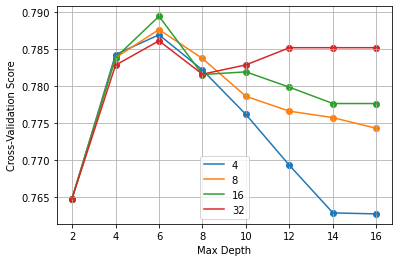

In [0]:
# plot
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list,
                          columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
  sel = cv_summary.minInst == mi
  plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
  plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])

plt.legend()
plt.grid()
plt.xticks(range(2,18,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')

plt.show()

## Problem 5: Structure of Final Model

In [0]:
# visualize tree
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_79dfe75261ac, depth=6, numNodes=53, numClasses=2, numFeatures=10
 If (feature 0 <= 56.5)
 If (feature 5 in {1.0})
 If (feature 9 in {3.0})
 Predict: 0.0
 Else (feature 9 not in {3.0})
 If (feature 4 in {1.0})
 Predict: 1.0
 Else (feature 4 not in {1.0})
 If (feature 2 <= 27.15)
 Predict: 1.0
 Else (feature 2 > 27.15)
 If (feature 3 in {1.0})
 Predict: 0.0
 Else (feature 3 not in {1.0})
 Predict: 1.0
 Else (feature 5 not in {1.0})
 If (feature 0 <= 43.5)
 If (feature 4 in {1.0})
 If (feature 2 <= 28.15)
 Predict: 1.0
 Else (feature 2 > 28.15)
 Predict: 0.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 0 > 43.5)
 If (feature 1 <= 156.44)
 If (feature 4 in {1.0})
 If (feature 9 in {0.0,2.0,3.0})
 Predict: 0.0
 Else (feature 9 not in {0.0,2.0,3.0})
 Predict: 1.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 1 > 156.44)
 If (feature 1 <= 236.815)
 Predict: 0.0
 Else (feature 1 > 236.815)
 Predict: 1.0
 Else (feature 0 > 56.5)
 If (feature 0 <= 81.5)
 If (feature 1 <= 118.485)
 If (feature 5 in {1.0})
 If (feature 0 <= 77.5)
 Predict: 1.0
 Else (feature 0 > 77.5)
 If (feature 1 <= 79.625)
 Predict: 1.0
 Else (feature 1 > 79.625)
 Predict: 0.0
 Else (feature 5 not in {1.0})
 If (feature 4 in {1.0})
 If (feature 2 <= 26.05)
 Predict: 1.0
 Else (feature 2 > 26.05)
 Predict: 0.0
 Else (feature 4 not in {1.0})
 Predict: 0.0
 Else (feature 1 > 118.485)
 If (feature 1 <= 236.815)
 If (feature 0 <= 62.5)
 If (feature 3 in {1.0})
 Predict: 0.0
 Else (feature 3 not in {1.0})
 Predict: 1.0
 Else (feature 0 > 62.5)
 If (feature 0 <= 77.5)
 Predict: 1.0
 Else (feature 0 > 77.5)
 Predict: 0.0
 Else (feature 1 > 236.815)
 If (feature 2 <= 29.35)
 If (feature 2 <= 26.05)
 Predict: 1.0
 Else (feature 2 > 26.05)
 Predict: 0.0
 Else (feature 2 > 29.35)
 Predict: 1.0
 Else (feature 0 > 81.5)
 Predict: 1.0

In [0]:
# get names and order of features in df
features = num_features + cat_features

# output results
print(features)

['age', 'avg_glucose_level', 'bmi', 'gender', 'hyptertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']

First Feature Used in Tree: age

Features Unused in Tree: ever_married, residence_type, work_type

In [0]:
pd.DataFrame({
    'feature':features,
    'importance':model.featureImportances
})

Out[10]:

,feature,importance
0,age,0.780537
1,avg_glucose_level,0.064422
2,bmi,0.022221
3,gender,0.004708
4,hyptertension,0.030844
5,heart_disease,0.088194
6,ever_married,0.000000
7,work_type,0.000000
8,residence_type,0.000000
9,smoking_status,0.009074


## Problem 6: Applying the Model to New Data

In [0]:
# new data
data = [
  ['Female', 42.0, 1, 0, 'No', 'Private', 'Urban', 182.1, 26.8, 'smokes'],
  ['Female', 64.0, 1, 1, 'Yes', 'Self-employed', 'Rural', 171.5, 32.5, 'formerly smoked'],
  ['Male', 37.0, 0, 0, 'Yes', 'Private', 'Rural', 79.2, 18.4, 'Unknown'],
  ['Male', 72.0, 0, 1, 'No', 'Govt_job', 'Urban', 125.7, 19.4, 'never smoked']
]

# make new data df
new_data = spark.createDataFrame(
  data,
  schema = ('gender STRING, age DOUBLE, hyptertension INTEGER, heart_disease INTEGER, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING')
)

# display new df
new_data.show()

+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
gender| age|hyptertension|heart_disease|ever_married| work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
Female|42.0| 1| 0| No| Private| Urban| 182.1|26.8| smokes|
Female|64.0| 1| 1| Yes|Self-employed| Rural| 171.5|32.5|formerly smoked|
 Male|37.0| 0| 0| Yes| Private| Rural| 79.2|18.4| Unknown|
 Male|72.0| 0| 1| No| Govt_job| Urban| 125.7|19.4| never smoked|
+------+----+-------------+-------------+------------+-------------+--------------+-----------------+----+---------------+

In [0]:
# apply processing pipeine
new_data_pcd = pre_pipe.transform(new_data)

# apply model
new_data_pred = model.transform(new_data_pcd)

# display results
new_data_pred.select('probability', 'prediction').show(truncate=False)

+-----------------------------------------+----------+
probability |prediction|
+-----------------------------------------+----------+
[0.3125,0.6875] |1.0 |
[0.3755020080321285,0.6244979919678715] |1.0 |
[0.9767441860465116,0.023255813953488372]|0.0 |
[0.3755020080321285,0.6244979919678715] |1.0 |
+-----------------------------------------+----------+